In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime

In [39]:
df_emas = pd.read_json("https://pluang.com/api/asset/gold/pricing?daysLimit=4001")
df_emas = pd.DataFrame(df_emas["data"]["history"])
df_emas = df_emas[["buy", "updated_at"]]
df_emas.rename(columns={'updated_at': 'date'}, inplace=True)

df_emas["date"] = df_emas["date"].apply(lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d"))
df_emas = df_emas.set_index('date')

data = df_emas.sort_values(by='date')
data = data.head(-20)

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [41]:
scaled_data.shape

(1981, 1)

In [42]:
time_step = 60

In [43]:
def create_dataset(dataset, time_step=time_step):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

In [44]:
X, y = create_dataset(scaled_data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [45]:
X.shape

(1921, 60, 1)

In [46]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [47]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


/opt/miniconda3/envs/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0117
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7624e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2836e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1487e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2000e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1612e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1567e-04
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1117e-04
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0518e-04
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1568e-04
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0703e-04
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2370e-04
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6945e-05
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0854e-04
Epoch 15/20
48/48 ━━━━━━━━━━━━

In [48]:
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


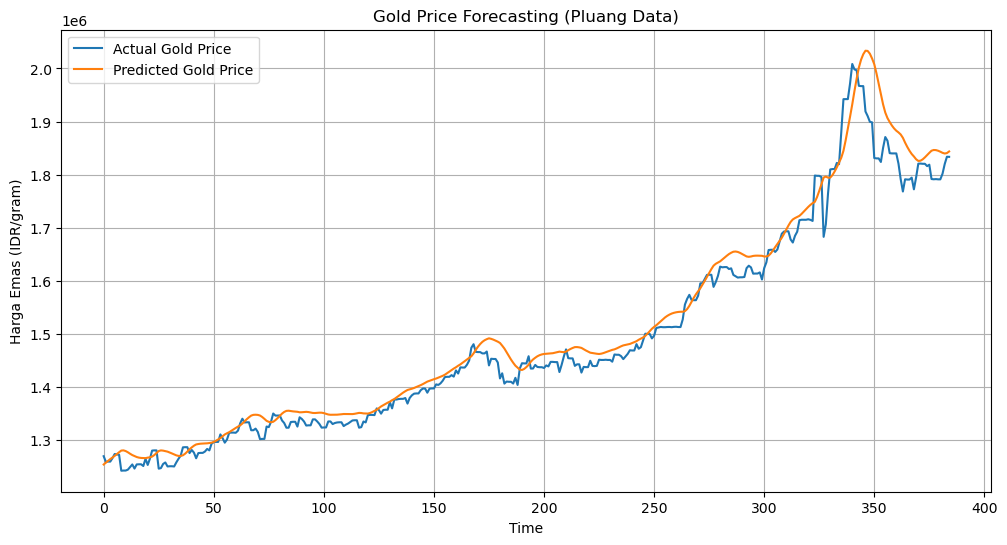

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Gold Price')
plt.plot(y_pred_inverse, label='Predicted Gold Price')
plt.title('Gold Price Forecasting (Pluang Data)')
plt.xlabel('Time')
plt.ylabel('Harga Emas (IDR/gram)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
future_steps = 30
last_time_step_days = scaled_data[-time_step:].reshape(1, time_step, 1)

future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_time_step_days)[0][0]
    future_predictions.append(next_pred)

    last_60_days = np.append(last_time_step_days[:, 1:, :], [[[next_pred]]], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [51]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

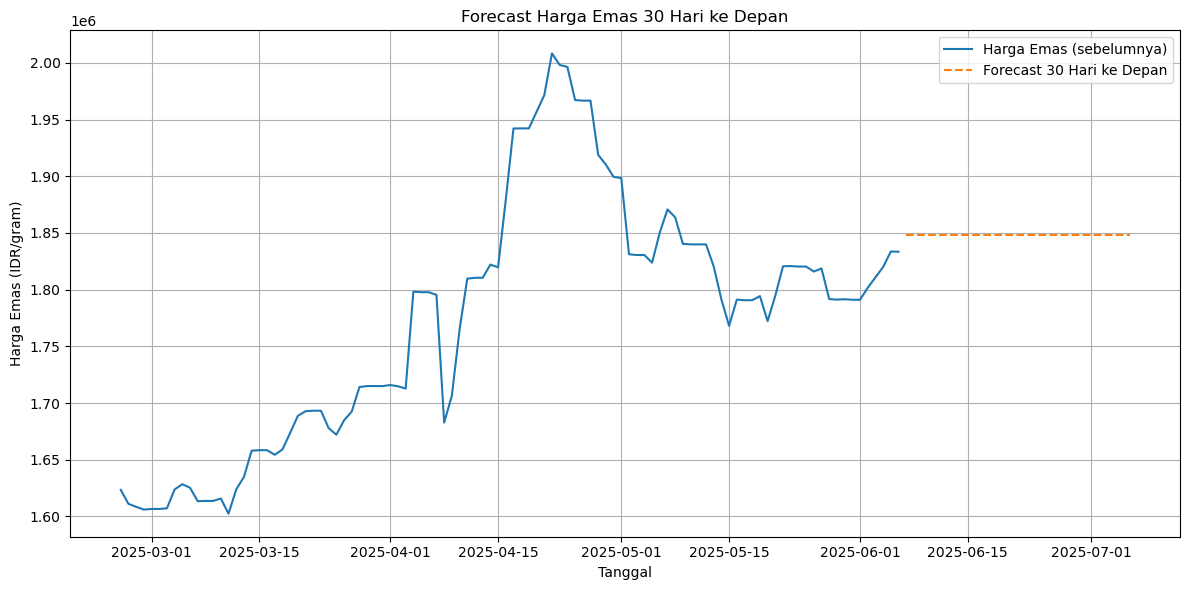

In [52]:
# 12. Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['buy'].values[-100:], label='Harga Emas (sebelumnya)')
plt.plot(future_dates, future_predictions, label='Forecast 30 Hari ke Depan', linestyle='--')
plt.title('Forecast Harga Emas 30 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR/gram)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()